In this notebook we numerically compute the probability distribution $p(H, E, \mathbf{x})$ over eigenenergies $E$ and Hamming distances $H$ from eigenstates to the reference $\mathbf{x}$. We see that it can be well approximated by a sum of one or two gaussians for the models studied.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import linalg
from problem_generator import *
from sklearn.neighbors import KernelDensity
from sklearn import mixture

import itertools
color_iter = itertools.cycle(["navy", "darkorange"])

sns.set(rc={'figure.figsize':(10,8)},style='white')

In [2]:
def max_min_Energy(E):
    "Find the maximum and minimum energy"
    Emax = np.max(E)
    ndxmax = np.where(E == Emax)[0]
    Emin = np.min(E)
    ndxmin = np.where(E == Emin)[0]
    return Emax, ndxmax, Emin, ndxmin

def Hamming(y):
    "Calculate the Hamming distances between y and every string of bits"
    N = len(y)
    bits = all_bit_strings(N)
    x = (bits-0.5)*2
    y = (y-0.5)*2
    return 1/2*(N-(x.T@y))

def EH_distribution(size,graph_type="Gnm",graph_arguments=1,ptname='QUBO'):
    "Compute the energy of every state and its Hamming distance to the ground state and the highest energy state of the system"
    E, _ = generate_interaction(size, ptname, graph_type, graph_arguments)

    Emax, ndxmax, Emin, ndxmin = max_min_Energy(E)
    bits = all_bit_strings(size)
    hamming_to_groundstate = Hamming(bits[:,ndxmin[0]])
    hamming_to_highestenergystate = Hamming(bits[:,ndxmax[0]])

    return E, hamming_to_groundstate, hamming_to_highestenergystate  

def get_samples(x,y,nsamples): 
    "Obtain nsamples drawn from a kernel density estimation (KDE) of the two-dimensional distribution given by x and y"  
    kde = KernelDensity().fit(np.column_stack((x,y)))
    samples= kde.sample(nsamples)
    Xsamples = samples[:,0]
    Ysamples = samples[:,1]
    return Xsamples,Ysamples

In [15]:
def gaussianmixture_fit(size, state='Ground_State' , data='Simulated', graph_type="Gnm",graph_arguments=1,ptname='QUBO',ngaussians=1,
                        nsamples=25000,save_file=None):

    #Generating sample
    Energy, H_groundstate, H_highestenergystate = EH_distribution(size,graph_type=graph_type,graph_arguments=graph_arguments,ptname=ptname)

    if data == 'Simulated':
       #We use the samples drawn from a kernel density estimation. It allows us to see the approximation to the continious probability
        if state=='Ground_State':
            E , H =get_samples(Energy,H_groundstate,nsamples)
        elif state=='Highest_energy_State':
            E , H =get_samples(Energy,H_highestenergystate,nsamples)      
    else:  
        #We use the actual data points, therefore it is a discrete distribution.
        E = Energy
        if state=='Ground_State':
            H = H_groundstate
        elif state=='Highest_energy_State':
            H = H_highestenergystate

    #Organizing data
    X = np.empty((len(E),2))
    X[:, 0] = E
    X[:, 1] = H

    #Fit to the Gaussian Mixture
    dpgmm = mixture.BayesianGaussianMixture(n_components=ngaussians,random_state=10, covariance_type="full",init_params='random').fit(X)
    Y_ = dpgmm.predict(X)
    means = dpgmm.means_
    covariances = dpgmm.covariances_
   
    #Plot the result
    fig, ax = plt.subplots()

    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    
    fs_labels=35 
    ax.set_ylabel(r'Hamming distance ($H_{\mathbf{x}\mathbf{x´}}$)',fontsize=fs_labels)
    ax.set_xlabel(r'Energy ($E_{\mathbf{x´}}$)',fontsize=fs_labels)
    ax.tick_params(labelsize=fs_labels)
    plt.ylim(0, size)
    if save_file:
        plt.savefig(save_file)
    plt.show()

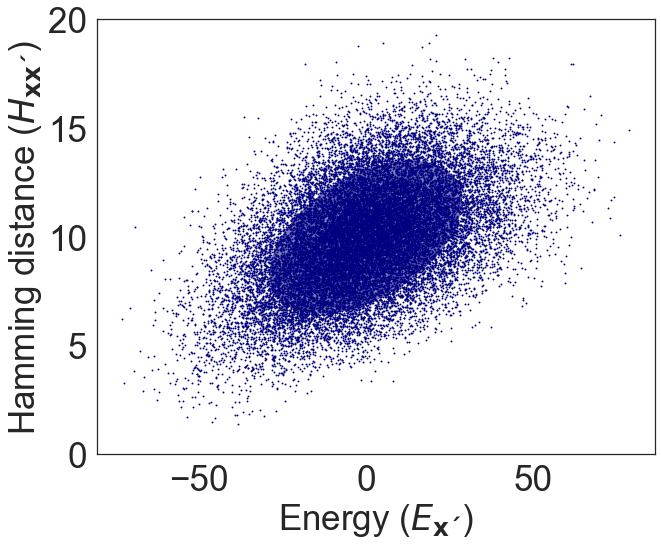

In [40]:
gaussianmixture_fit(20, state='Ground_State' , data='Simulated',ptname='QUBO',ngaussians=1,save_file=False)

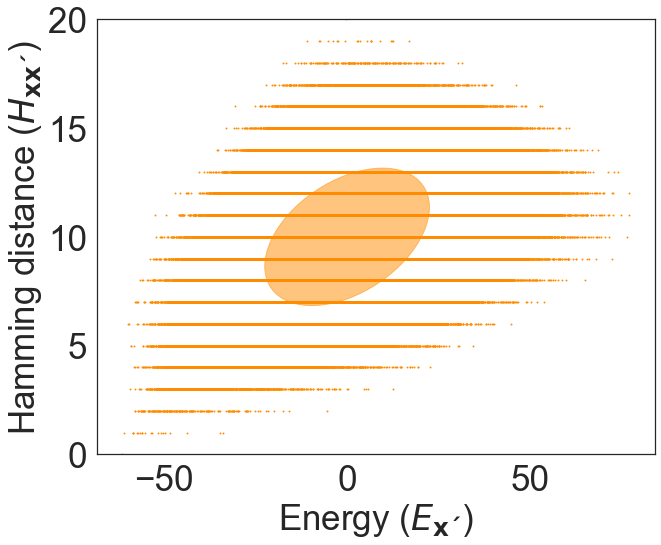

In [41]:
gaussianmixture_fit(20, state='Ground_State' , data='Real',ptname='QUBO',ngaussians=1,save_file=False)

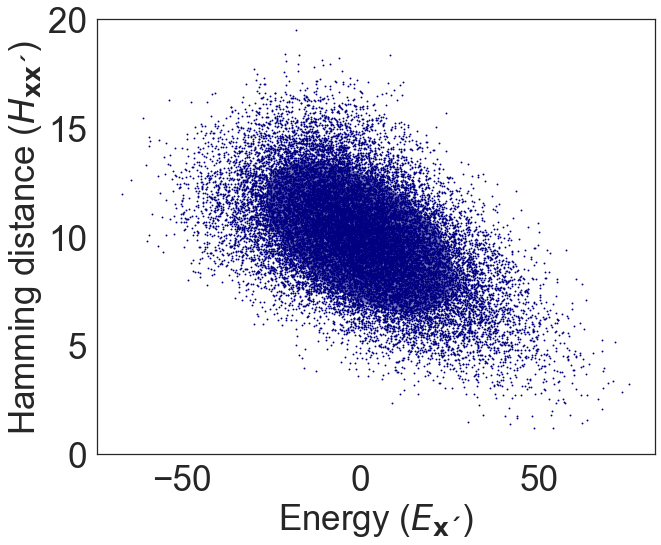

In [42]:
gaussianmixture_fit(20, state='Highest_energy_State' , data='Simulated',ptname='QUBO',ngaussians=1,save_file=False)

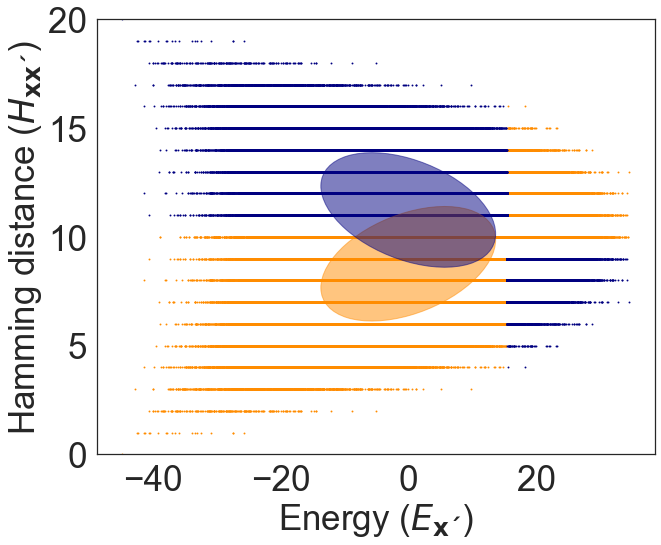

In [45]:
gaussianmixture_fit(20, state='Ground_State' , data='Real',ptname='MAXCUT',ngaussians=2,save_file=False)

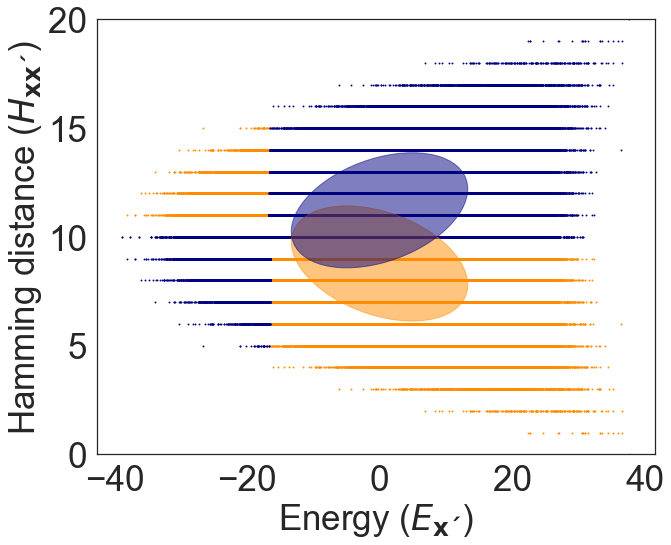

In [46]:
gaussianmixture_fit(20, state='Highest_energy_State' , data='Real',ptname='MAXCUT',ngaussians=2,save_file=False)

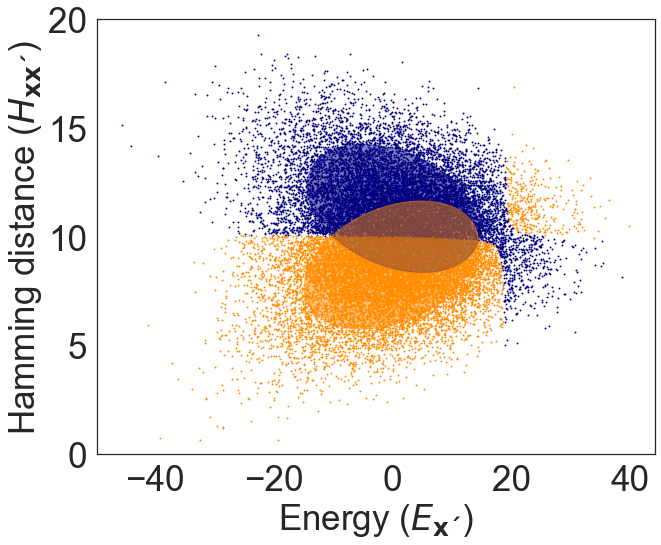

In [12]:
gaussianmixture_fit(20, state='Ground_State' , data='Simulated',ptname='MAXCUT',ngaussians=2,save_file=False)

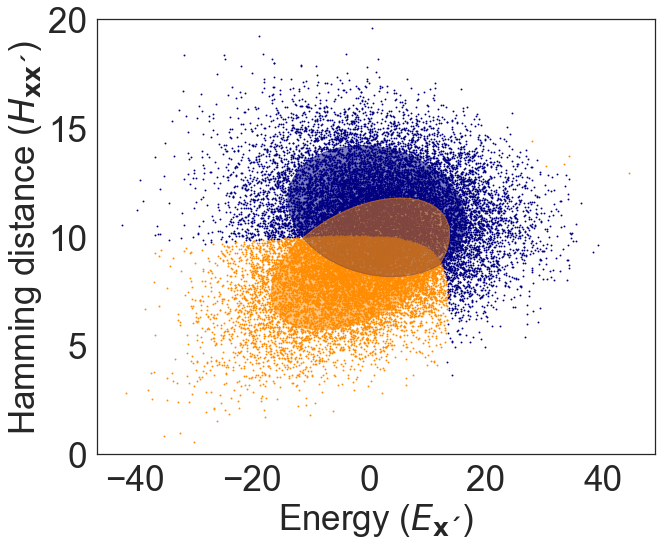

In [9]:
gaussianmixture_fit(20, state='Ground_State' , data='Simulated',ptname='Random_Ising',ngaussians=2,save_file=False)